In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import numpy as np

# file path
mouse_metadata_path = "resources/Mouse_metadata.csv"
study_results_path = "resources/Study_results.csv"

# create dataframes
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)


In [ ]:
## OBSERVATIONS:

##
# Distribution of sex in mice is nearly evenly split at F = 124, M=125, however we have no data on the level of efficacy of treatment relative to sex.  This should prompt further
# investigation on how each drug regimen had success relative to the sex of mice.  

##
# Upon searching for possible outliers amongst the most promising treatment regimens, their was one potential outlier in the final volumes for mice treated with Infubinol. However,
# the sample sizes were quite small.  Larger samples might be necessary to find out whether outliers are more common in subsets of the population that more precisely reflect the 
# population at large.

##
# Upon investigating the effect over time on a mouse treated with Capomulin, the tumor volume showed a significant decrease in volume.  However, by comparison, the average rate
# of reduction in tumor size for mice treated with Capomulin was much less drastic.  Confirming this, the standard deviation of mice treated with Capomulin 
# on the 45th day was 5.6. This means that the spread in tumor volumes at the end of the treatment period varied significantly.  

##
# correlation coefficient for weight vs. average tumor size for mice treated with Capomulin shows a strong positive relationship between the two variables.  This means that weight is 
# associated strongly with the volume of the tumor.      

In [2]:
# drop duplicates and store as clean df
mouse_df = pd.merge(mouse_metadata, study_results, on="Mouse ID", how="outer")
mouse_df.drop_duplicates(subset=["Mouse ID", "Timepoint", "Tumor Volume (mm3)", "Metastatic Sites"], inplace=True, ignore_index=True)
mouse_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1887,z969,Naftisol,Male,9,30,25,63.145652,2
1888,z969,Naftisol,Male,9,30,30,65.841013,3
1889,z969,Naftisol,Male,9,30,35,69.176246,4
1890,z969,Naftisol,Male,9,30,40,70.314904,4


In [4]:
# generate summary statistics for drug regimen
regimen_index = mouse_df.set_index("Drug Regimen")
sum_stat = regimen_index.loc[:, ["Tumor Volume (mm3)"]]
grpby_stat = sum_stat.groupby(["Drug Regimen"])
mean = grpby_stat["Tumor Volume (mm3)"].mean()
median = grpby_stat["Tumor Volume (mm3)"].median()
variance = grpby_stat["Tumor Volume (mm3)"].var()
standard_dev = grpby_stat["Tumor Volume (mm3)"].std()
sem = grpby_stat["Tumor Volume (mm3)"].sem()

sum_statistics = pd.DataFrame({"Mean": mean, 
                        "Median": median, 
                        "Variance": variance,
                        "Standard Deviation": standard_dev,
                        "SEM": sem})
sum_statistics

,Mean,Median,Variance,Standard Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.368318,50.909965,42.278090,6.502160,0.514041
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [38]:
# generate summary statistics for drug regimen at each time point
a = regimen_index.loc[:, ["Timepoint", "Tumor Volume (mm3)"]]
b = a.groupby(["Drug Regimen", "Timepoint"])
c = b["Tumor Volume (mm3)"].mean()
d = b["Tumor Volume (mm3)"].median()
e = b["Tumor Volume (mm3)"].var()
f = b["Tumor Volume (mm3)"].std()
g = b["Tumor Volume (mm3)"].sem()

summary_stat_timepoint = pd.DataFrame({"Mean": c, 
                        "Median": d, 
                        "Variance": e,
                        "Standard Deviation": f,
                        "SEM": g})
summary_stat_timepoint.head(25)

Mean     Median   Variance  Standard Deviation  \
Drug Regimen Timepoint                                                        
Capomulin    0          45.000000  45.000000   0.000000            0.000000   
             5          44.266086  45.597064   5.030889            2.242964   
             10         43.084291  43.421014  12.344133            3.513422   
             15         42.064317  42.798160  16.878693            4.108369   
             20         40.716325  40.716428  19.035028            4.362915   
             25         39.939528  40.224165  17.100444            4.135268   
             30         38.769339  39.260371  19.210721            4.383004   
             35         37.816839  38.360455  24.358640            4.935447   
             40         36.958001  36.843898  31.441568            5.607278   
             45         36.236114  37.311846  31.460537            5.608969   
Ceftamin     0          45.000000  45.000000   0.000000            0.000000   
             5          46.503051  46.370798   0.568299            0.753856   
             10         48.285125  48.164520   1.115284            1.056070   
             15         50.094055  49.746427   2.094922            1.447385   
             20         52.157049  52.112973   2.326097            1.525155   
             25         54.287674  54.275954   3.474610            1.864031   
             30         56.769517  56.362744   3.851331            1.962481   
             35         58.827548  58.208362   6.708893            2.590153   
             40         61.467895  60.600972   7.027713            2.650983   
             45         64.132421  64.299830  10.585242            3.253497   
Infubinol    0          45.000000  45.000000   0.000000            0.000000   
             5          46.541247  46.870483   5.689821            2.385335   
             10         49.403909  49.471244   1.674104            1.293872   
             15         51.296397  51.265440   2.687010            1.639210   
             20         53.197691  53.862724   4.535510            2.129674   

                             SEM  
Drug Regimen Timepoint            
Capomulin    0          0.000000  
             5          0.448593  
             10         0.702684  
             15         0.838617  
             20         0.909731  
             25         0.881642  
             30         0.934460  
             35         1.052241  
             40         1.223608  
             45         1.223977  
Ceftamin     0          0.000000  
             5          0.164505  
             10         0.236144  
             15         0.332053  
             20         0.359482  
             25         0.439356  
             30         0.490620  
             35         0.692248  
             40         0.708505  
             45         0.902358  
Infubinol    0          0.000000  
             5          0.477067  
             10         0.282346  
             15         0.357705  
             20         0.476210

In [6]:
# create dataframe showing total mice for each treatment regimen throughout the course of study

g_t_r = mouse_df[["Mouse ID", "Timepoint", "Drug Regimen"]]
g_t_r_grp = g_t_r.groupby(["Timepoint", "Drug Regimen"])["Timepoint"].count().unstack("Drug Regimen")
g_t_r_grp

Drug Regimen,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,25,25,24,25
5,25,21,25,23,23,24,25,25,23,24
10,25,20,21,22,21,24,23,24,21,22
15,24,19,21,19,21,20,17,24,21,21
20,23,18,20,19,20,19,17,23,19,17
25,22,18,18,19,18,17,14,23,18,16
30,22,16,17,18,15,15,13,23,17,15
35,22,14,12,17,15,14,10,21,15,14
40,21,14,10,15,15,12,9,20,12,14


<AxesSubplot:title={'center':'Number of Mice treated by Drug Regimen'}, xlabel='Time Interval (5 days)', ylabel='Total Number of Mice'>

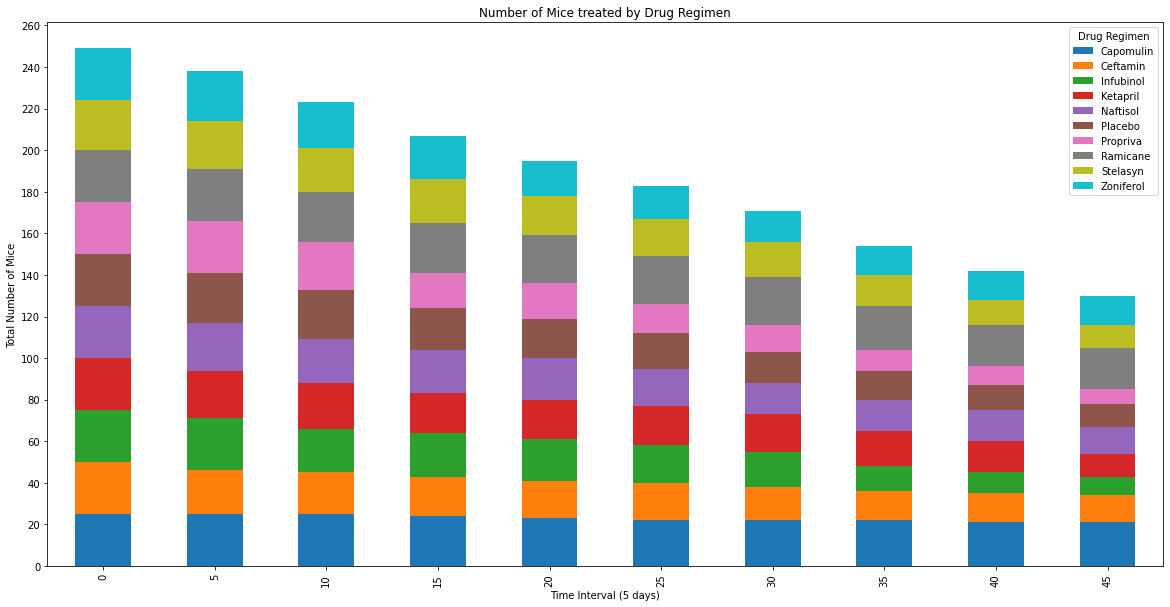

In [7]:
# generate a bar plot using DataFrame.plot()
y_ticks = np.arange(0, 280, 20.0)
g_t_r_grp.plot(kind='bar', stacked=True, figsize=(20,10), 
                title="Number of Mice treated by Drug Regimen", 
                xlabel="Time Interval (5 days)", ylabel="Total Number of Mice", 
                yticks=y_ticks)

In [8]:
# create a dataframe showing distribution by sex for dataset
df_copy2 = mouse_df.copy()
df_copy2.drop_duplicates(subset=["Mouse ID", "Sex"], inplace=True, ignore_index=True)
groupby_sex = df_copy2[["Mouse ID", "Sex"]].groupby("Sex")
sex_count_series = groupby_sex["Mouse ID"].count()
ID_sex_df = pd.DataFrame(sex_count_series)
ID_sex_df


,Mouse ID
Sex,
Female,124
Male,125


<AxesSubplot:ylabel='Mouse ID'>

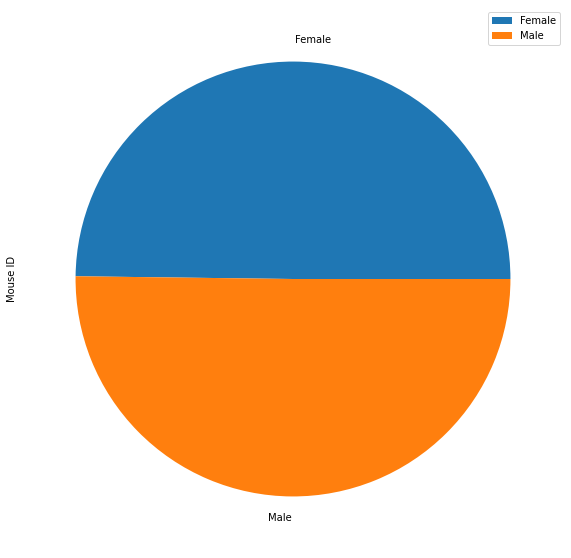

In [36]:
# generate pie plot for distribution by sex using DataFrame.plot
ID_sex_df.plot(kind="pie", y="Mouse ID", figsize=(20,10))

In [32]:
# find final tumor volume 
f_t_v = mouse_df.loc[(mouse_df["Drug Regimen"] == "Capomulin") | 
                                        (mouse_df["Drug Regimen"] == "Ramicane") | 
                                        (mouse_df["Drug Regimen"] == "Infubinol") | 
                                        (mouse_df["Drug Regimen"] == "Ceftamin"), 
                                        ["Drug Regimen", "Mouse ID", "Tumor Volume (mm3)", "Timepoint"]]
f_t_v.drop_duplicates(subset=("Mouse ID", "Drug Regimen"), keep="last", inplace=True, ignore_index=True)
f_t_v

,Drug Regimen,Mouse ID,Tumor Volume (mm3),Timepoint
0,Ramicane,k403,22.050126,45
1,Capomulin,s185,23.343598,45
2,Capomulin,x401,28.484033,45
3,Capomulin,m601,28.430964,45
4,Ramicane,g791,29.128472,45
...,...,...,...,...
95,Ceftamin,x822,61.386660,45
96,Infubinol,y163,67.685569,45
97,Ceftamin,y769,68.594745,45
98,Ceftamin,y865,64.729837,45


In [12]:
# calculate final tumor volume of each mouse across four of the most promising treatment regimens: Capomulin, Ramicane, Infubinol, and Ceftamin
ftv_capomulin = f_t_v.loc[(f_t_v["Drug Regimen"] == "Capomulin"), ["Mouse ID", "Tumor Volume (mm3)"]].set_index("Mouse ID")

ftv_ramicane = f_t_v.loc[(f_t_v["Drug Regimen"] == "Ramicane"), ["Mouse ID", "Tumor Volume (mm3)"]].set_index("Mouse ID")

ftv_infubinol = f_t_v.loc[(f_t_v["Drug Regimen"] == "Infubinol"), ["Mouse ID", "Tumor Volume (mm3)"]].set_index("Mouse ID")

ftv_ceftamin = f_t_v.loc[(f_t_v["Drug Regimen"] == "Ceftamin"), ["Mouse ID", "Tumor Volume (mm3)"]].set_index("Mouse ID")

In [13]:
# quartiles, IQR Capomulin
q_cap = ftv_capomulin["Tumor Volume (mm3)"].quantile([.25,.5,.75])
lq_cap = q_cap[0.25]
uq_cap = q_cap[0.75]
mid_cap = q_cap[0.50]
iqr_cap = uq_cap - lq_cap
lwr_b_cap = lq_cap - (1.5 * iqr_cap)
up_b_cap = uq_cap + (1.5 * iqr_cap)

# quartiles, IQR Ramicane
q_ram = ftv_ramicane["Tumor Volume (mm3)"].quantile([.25,.5,.75])
lq_ram = q_ram[0.25]
uq_ram = q_ram[0.75]
mid_ram = q_ram[0.50]
iqr_ram = uq_ram - lq_ram
lwr_b_ram = lq_ram - (1.5 * iqr_ram)
up_b_ram = uq_ram + (1.5 * iqr_ram)

# quartiles, IQR Infubinol
q_inf = ftv_infubinol["Tumor Volume (mm3)"].quantile([.25,.5,.75])
lq_inf = q_inf[0.25]
uq_inf = q_inf[0.75]
mid_inf = q_inf[0.50]
iqr_inf = uq_inf - lq_inf
lwr_b_inf = lq_inf - (1.5 * iqr_inf)
up_b_inf = uq_inf + (1.5 * iqr_inf)

# quartiles, IQR Ceftamin
q_cef = ftv_ceftamin["Tumor Volume (mm3)"].quantile([.25,.5,.75])
lq_cef = q_cef[0.25]
uq_cef = q_cef[0.75]
mid_cef = q_cef[0.50]
iqr_cef = uq_cef - lq_cef
lwr_b_cef = lq_cef - (1.5 * iqr_cef)
up_b_cef = uq_cef + (1.5 * iqr_cef)


In [22]:
# Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers across all four treatment regimens.

# Identify outliers quantitatively for Capomulin, Ramicane, Infubinol, and Ceftamin
outliers_cap = ftv_capomulin.loc[(ftv_capomulin["Tumor Volume (mm3)"] < lwr_b_cap) | (ftv_capomulin["Tumor Volume (mm3)"] > up_b_cap)]

outliers_ram = ftv_ramicane.loc[(ftv_ramicane["Tumor Volume (mm3)"] < lwr_b_ram) | (ftv_ramicane["Tumor Volume (mm3)"] > up_b_ram)]

outliers_inf = ftv_infubinol.loc[(ftv_infubinol["Tumor Volume (mm3)"] < lwr_b_inf) | (ftv_infubinol["Tumor Volume (mm3)"] > up_b_inf)]

outliers_cef = ftv_ceftamin.loc[(ftv_ceftamin["Tumor Volume (mm3)"] < lwr_b_cef) | (ftv_ceftamin["Tumor Volume (mm3)"] > up_b_cef)]
print(outliers_cap)
print(outliers_ram)
print(outliers_inf)
print(outliers_cef)


Empty DataFrame
Columns: [Tumor Volume (mm3)]
Index: []
Empty DataFrame
Columns: [Tumor Volume (mm3)]
Index: []
          Tumor Volume (mm3)
Mouse ID                    
c326               36.321346
Empty DataFrame
Columns: [Tumor Volume (mm3)]
Index: []


/Users/kinlaydenning/opt/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


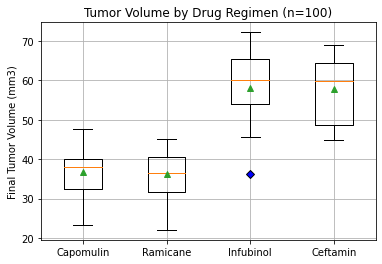

In [34]:
# box and whisker plot for outliers in promising treatments
data = [ftv_capomulin["Tumor Volume (mm3)"], ftv_ramicane["Tumor Volume (mm3)"], ftv_infubinol["Tumor Volume (mm3)"], ftv_ceftamin["Tumor Volume (mm3)"]]

outlier = dict(markerfacecolor='b', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Tumor Volume by Drug Regimen (n=100)')
ax1.set_xticklabels(["Capomulin", "Ramicane", "Infubinol", "Ceftamin"])
ax1.set_ylabel('Final Tumor Volume (mm3)')
plt.boxplot(data, showmeans=True, flierprops=outlier)
plt.grid()
plt.show()


In [ ]:
# In Drug Regimen = Capomulin, isolate a single mouse ID
id_cap_treatment = mouse_df.loc[mouse_df["Drug Regimen"] == "Capomulin", ["Drug Regimen", "Mouse ID", "Tumor Volume (mm3)", "Timepoint"]]

ran_id = id_cap_treatment.loc[id_cap_treatment["Mouse ID"] == "s185", ["Mouse ID", "Tumor Volume (mm3)", "Timepoint"]].set_index("Mouse ID")

ran_id

,Tumor Volume (mm3),Timepoint
Mouse ID,,
s185,45.000000,0
s185,43.878496,5
s185,37.614948,10
s185,38.177232,15
s185,36.866876,20
s185,33.949940,25
s185,32.959671,30
s185,28.328531,35
s185,25.472143,40


Text(0, 0.5, 'Tumor Volume (mm3)')

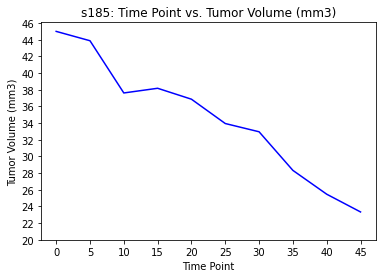

In [ ]:
# generate line plot of tumor volume vs time point for Mouse ID: s185
plt.plot(ran_id["Timepoint"], ran_id["Tumor Volume (mm3)"], color="blue")
plt.title("s185: Time Point vs. Tumor Volume (mm3)")
plt.yticks(np.arange(min(ran_id["Tumor Volume (mm3)"]) -3.34, max(ran_id["Tumor Volume (mm3)"]) + 1.5, 2.0))
plt.xticks(np.arange(min(ran_id["Timepoint"]), max(ran_id["Timepoint"]) + 1, 5.0))
plt.xlabel("Time Point")
plt.ylabel("Tumor Volume (mm3)")

In [37]:
# generate scatter plot of mouse weight vs. average tumor volume for the Capomulin treatment regimen
capomulin_df = mouse_df.loc[mouse_df["Drug Regimen"] == "Capomulin", ["Mouse ID", "Tumor Volume (mm3)", "Weight (g)"]]
cap_group = capomulin_df.groupby(["Mouse ID", "Weight (g)"])
cap_group_ave = cap_group["Tumor Volume (mm3)"].mean()

ave_vol_vs_weight_df = pd.DataFrame(cap_group_ave).reset_index()
vol_vs_weight_indexed = ave_vol_vs_weight_df.set_index("Mouse ID")

vol_vs_weight_indexed.head()

,Weight (g),Tumor Volume (mm3)
Mouse ID,,
b128,22,41.963636
b742,21,40.083699
f966,17,36.505973
g288,19,41.990097
g316,22,44.613344


In [25]:
# calculate a linear regression model
weight_series = pd.Series(vol_vs_weight_indexed["Weight (g)"])
tumor_vol_series = pd.Series(vol_vs_weight_indexed["Tumor Volume (mm3)"])
(slope, intercept, rvalue, pvalue, stderr) = sts.linregress(weight_series, tumor_vol_series)
regress_values = weight_series * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# calculate the correlation coefficient between mouse weight vs. average tumor volume for the Capomulin treatment regimen
correlation_coefficient_df = vol_vs_weight_indexed.corr()
correlation_coefficient_df

,Weight (g),Tumor Volume (mm3)
Weight (g),1.000000,0.841936
Tumor Volume (mm3),0.841936,1.000000


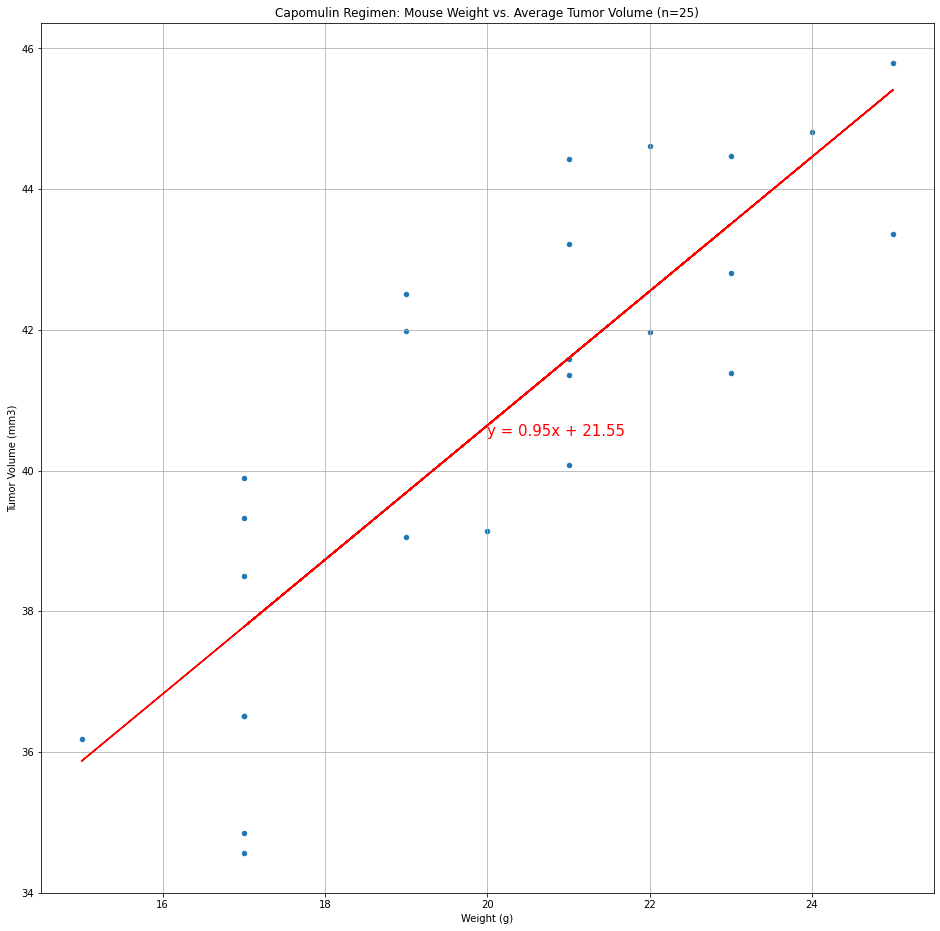

In [35]:
# plot graph with linear regression line
vol_vs_weight_indexed.plot(kind="scatter", x="Weight (g)", y="Tumor Volume (mm3)", grid=True, figsize=(16,16), title="Capomulin Regimen: Mouse Weight vs. Average Tumor Volume (n=25)")
plt.plot(weight_series,regress_values,"r-")
plt.annotate(line_eq,(20,40.5),fontsize=15,color="red")
plt.show()